# Assignment 3: LDA Topic Modeling

## Note
Installing Tomotopy locally can return an error, if that's the case run this notebook on Google Colab

## Research Background

LDA is a popular topic modeling algorithm widely used in the fields of Digital Humanities and Social Sciences. In the field of political communication, topic modeling is often applied for analyzing politicians Twitter/X posts, identitying thematic patterns or topics revolving around their posts.

For this assignment, students will work with tweets from two USA politicians, Donald Trump and Bernie Sanders, who are often regarded as right-wing populist and left-wing populist respectively. Right-wing populism often emphasizes nationalism, anti-immigration policies, and a critique of global elites from a culturally conservative perspective, focusing on preserving traditional values and social hierarchies. Left-wing populism prioritizes economic inequality, advocating for the redistribution of wealth, expansion of social services, and empowerment of the working class against the capitalist elite. While both forms of populism appeal to the "common people" against perceived elites and established structures, they diverge significantly in their identification of the elites, proposed solutions, and core ideologies. For a more detailed explanation, you can read the chapter by Macaulay (2019) "Bernie and The Donald: A comparison of left-and right-wing populist discourse" (full reference below).

**Research Questions**
1. What topics are revolving around Donald Trump and Bernie Sanders' posts separately?
2. What are the topic differences between Trump (right-wing popoulist) and Sanders (left-wing populist)?

**Aim:**
1. The first aim of the assignment is to conduct LDA topic modeling. Identify thematic patterns or politics revolving around Trump or Sanders's posts.
2. The second aim is to critically evaluate the results of topic modeling. Try different numbers of topics to see with which settings the topics are more coherent. Critically reflect on the results of LDA topic modeling, discussing them in relation to existing theories about populism.

**Data**
Two datasets are prepared for this assginment. Tweets from Trump and tweets from Sanders. Students are asked to work on these two datasets.

**Methods**
1. Word segamentation
2. Removing stopwords
3. LDA topic modeling
4. Topic evaulation (coherence and human evaluation)
5. Visualization of results.

**References**
1. Macaulay, M. (2019). Bernie and the Donald: A comparison of Left-and Right-wing populist discourse. *Populist discourse: International perspectives*, 165-195.





## Setup

### Q1. Install necessary libraries, including `tomotopy` and `little_mallet_wrapper`, and import them

In [17]:
# Q1 (code)
# Install tomotopy and little_mallet_wrapper libraries
!pip install tomotopy
!pip install little_mallet_wrapper

In [18]:
# Import the two libraries
import tomotopy as tp
from little_mallet_wrapper import process_string, train_topic_model, plot_categories_by_topics_heatmap

## Data preprocessing

### Q2. Load the two datasets and concatenate them

The goal is to run topic modelling on the combined dataset of Sanders and Trump's tweets

In [19]:
# Q2 (code)
# Install and import Pandas
!pip install pandas
import pandas as pd

In [20]:
# Load the two datasets
trump_tweets = pd.read_csv(r'C:\Users\ASUS\Desktop\Assignment3-AD\trump_tweets.csv')
sanders_tweets = pd.read_csv(r'C:\Users\ASUS\Desktop\Assignment3-AD\sanders_tweets.csv')

In [21]:
trump_tweets['Politician'] = 'Trump'
sanders_tweets['Politician'] = 'Sanders'

# Use the pd.concat() function to concatenate the datasets
combined_tweets = pd.concat([trump_tweets, sanders_tweets]).reset_index(drop=True)
print(combined_tweets.head())

           Username             TweetId                                Title  \
0  @realDonaldTrump  822421390125043713  @realDonaldTrump_822421390125043713   
1  @realDonaldTrump  822501803615014918  @realDonaldTrump_822501803615014918   
2  @realDonaldTrump  822501939267141634  @realDonaldTrump_822501939267141634   
3  @realDonaldTrump  822502135233384448  @realDonaldTrump_822502135233384448   
4  @realDonaldTrump  822502270503972872  @realDonaldTrump_822502270503972872   

                                             Content Politician  
0   It all begins today! I will see you at 11:00 ...      Trump  
1   Today we are not merely transferring power fr...      Trump  
2   power from Washington, D.C. and giving it bac...      Trump  
3   What truly matters is not which party control...      Trump  
4   January 20th 2017, will be remembered as the ...      Trump  


### Q3. Clean the data

Transform all tweets to lowercase, remove stopwords, punctuation, and numbers. Add the processed text to a list called `training_data`.
Create a list with the content of the tweets (`original_texts`) and a list that allows you to identify both the author of the tweet and its ID (`titles`).


In [22]:
# Q3 (code)
# Install and import necessary libraries
! pip install nltk
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
#  Define a function to clean the tweets
def clean_tweet(tweet):
    stop_words = set(stopwords.words('english'))
    processed_text = tweet
    # Remove URLs, user mentions, and specific usernames
    processed_text = re.sub(r"http\S+|www\S+|https\S+|\/\/t\.co\/|\@\w+|#", '', processed_text, flags=re.MULTILINE)
    # Convert to lowercase
    processed_text = processed_text.lower()
    # Remove words like "rt" and "amp" 
    processed_text = re.sub(r'\brt\b|\bamp\b', '', processed_text)
    # Remove punctuation and numbers
    processed_text = re.sub(r'[“”‘’"\'\`]', '', processed_text)
    processed_text = re.sub(r'[^\w\s]', '', processed_text)
    # Tokenize
    tokens = word_tokenize(processed_text)
    # Remove stopwords
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # Re-join the tokens into a string
    cleaned_tweet = ' '.join(filtered_tokens)
    return cleaned_tweet

In [24]:
# List to store cleaned tweet texts for LDA analysis.
training_data = [] 

original_texts = []  

# List to store identifiers for each tweet.
titles = []  

# Iterate over each row in the DataFrame `combined_tweets`
for index, row in combined_tweets.iterrows():
    cleaned_text = clean_tweet(row['Content'])
    # Add the cleaned tweet text to the `training_data` list.
    training_data.append(cleaned_text)
    # Add the original tweet text (before cleaning) to the `original_texts` list.
    original_texts.append(row['Content'])
    # Create a unique identifier for the tweet by concatenating the user's username
    titles.append(f"{row['Username']}_{row['TweetId']}")

In [25]:
# Check the first rows of processed texts
print(training_data[:5])
len(training_data),len(original_texts),len(titles)

['begins today see 1100 swearingin movement continues work begins', 'today merely transferring power one administration another one party another äì transferring', 'power washington dc giving back american people inaugurationday', 'truly matters party controls government whether government controlled people', 'january 20th 2017 remembered day people became rulers nation']


(30371, 30371, 30371)

## LDA topic modelling

### Q4. Train a an LDA topic model with `tomotopy`

In [26]:
# Q4 (code)
# Number of topics to return
num_topics = 15
# Numer of topic words to print out
num_topic_words = 10

# Create an LDA model instance
model = tp.LDAModel(k=num_topics)

# Add each document to the model, after splitting it up into words
for text in training_data:
    model.add_doc(text.strip().split())

print("Topic Model Training...\n\n")
# Iterate over the data 10 times
iterations = 10
for i in range(0, 100, iterations):
    model.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {model.ll_per_word}')

Topic Model Training...


Iteration: 0	Log-likelihood: -9.441536091569722
Iteration: 10	Log-likelihood: -9.026211735570996
Iteration: 20	Log-likelihood: -8.833587943262609
Iteration: 30	Log-likelihood: -8.734423352203663
Iteration: 40	Log-likelihood: -8.66285400796025
Iteration: 50	Log-likelihood: -8.616903401046132
Iteration: 60	Log-likelihood: -8.584154955155396
Iteration: 70	Log-likelihood: -8.561929080447495
Iteration: 80	Log-likelihood: -8.546602633735219
Iteration: 90	Log-likelihood: -8.533397525309288


### Q5. Print out the top words for each topic and manually evaluate their coherence


In [27]:
# Q5a (code)
# Print out top 10 words for each topic
print("\nTopic Model Results:\n\n")

topics = []
topic_individual_words = []
for topic_number in range(0, num_topics):
    topic_words = ' '.join(word for word, prob in model.get_topic_words(topic_id=topic_number, top_n=num_topic_words))
    topics.append(topic_words)
    topic_individual_words.append(topic_words.split())
    print(f"✨Topic {topic_number}✨\n\n{topic_words}\n")


Topic Model Results:


✨Topic 0✨

great president thank trade today america country day united american

✨Topic 1✨

democrats republicans senate impeachment vote want house republican people dems

✨Topic 2✨

tax million jobs billion years year americans 1 trump class

✨Topic 3✨

president trump live news pm tonight call house watch schiff

✨Topic 4✨

health care people workers must right country every americans american

✨Topic 5✨

us states china united much countries many would money dollars

✨Topic 6✨

trump fbi russia witch hunt campaign collusion hillary obama clinton

✨Topic 7✨

news fake media people never like even would many bad

✨Topic 8✨

change must drug climate energy people street wall prices industry

✨Topic 9✨

court justice supreme trump president judge law case report mueller

✨Topic 10✨

great thank state total vote endorsement big maga complete strong

✨Topic 11✨

biden joe trump election president record history ever economy best

✨Topic 12✨

president trump must 

# Q5b (words)
# Describe what each topic is about. What ideas, values, or situations do these keywords refer to?

✨Topic 0✨
great thank president today house white new forward live pm

This topic is related to the White House, especially some events such as official statements and important speeches. The keywords "great", "thank", and "president" may represent the praise for the president and his achievements. In addition, such words as "white house", "today” and "pm" may suggest that this topic also focus on the president's daily activities and special announcements.


✨Topic 1✨
trump russia fbi collusion witch hunt mueller campaign hillary president

This topic covers some political controversies during the Trump presidency,including allegations of Russian interference in the presidential election. The keywords "collusion", "witch hunt", "mueller" and "FBI" may indicate the investigation and public discussion about this controversy. Besides, the word "hillary" may refer to Trump's 2016 presidential rival, Hillary Clinton.


✨Topic 2✨
vote election win big republican trump get state 2020 great

This topic focuses on the presidential election and the performance of Trump and his Party in 2020. The keywords such as "vote", "election", "win" and "2020" are directly related to the election campaign and result. This suggests that the topic highlights Trump's success in the political area.

✨Topic 3✨
health care people country right must make need every system

This topic focuses on health insurance and the health care system. It also involves the need for health care coverage and health care reform. Keywords such as "health care", "system" and "need" underscore the significance of improving the country's health care system, and reflect a critical need for more equitable and accessible health care.


✨Topic 4✨
great thank total endorsement military strong state complete amendment vote

This topic focuses on national security, military force, and constitutional amendments. Keywords such as "military", "strong", and "amendment" may refer to military policy, defense budgets, or changes in the law. The word "endorsement" may suggest political support and approval.

✨Topic 5✨
must people change congress drug americans climate american working bill

This topic involves American domestic issues, including climate change, pharmaceutical regulations, and labor law. It reflects a focus on legislative activity in Congress, particularly on some bills. According to the words "climate", "drug" and  "bill", it can be assumed that this topic specifically discusses environmental policy and health regulations.

✨Topic 6✨
wage federal minimum money new hour 15 wall big would

This topic is related to minimum wage laws, economic policy, and government regulations. The words "federal", "minimum", "wage" and "money" suggest discussion of an increase in the federal minimum wage. In addition, "wall" may represent the border wall, reflecting the controversies over border security and immigration policy.

✨Topic 7✨
people us war must states iran help together puerto united

This topic is related to international relations and foreign policy. The words "Iran" and "Puerto" indicate that it foucses on the two counties, Iran and Puerto Rico. Keywords such as "war", "iran" and "united" may suggest diplomatic crises. Moreover, "puerto" may refer to the assistance to Puerto Rico and the responsibility of the United States. It may also reflect the significance of the United States in international relations.

✨Topic 8✨
news fake media joe biden like would even people never

This topic focues on media criticism and "fake news" is a phrase often mentioned in Trump's tweets.It also lashes out inaccurate political coverage. The keywords "fake", "media", and "news" represent the distrust of Amercian major media. Additonally, the word "joe biden" could mean that Trump criticizes his political opponents.

✨Topic 9✨
tax million billion 1 americans workers year security social pay

This topic focuses on tax policy, social security, and economic issues. Keywords such as "tax", "million", "billion", "social security", "worker", and "pay" may represent the government's fiscal policies and these policies may target average American workers. This topic also involves improving economic conditions and increasing people's welfare.

✨Topic 10✨
court america women country day today american people thank great

This topic involves the legal and judicial systems of the United States. The word "women" may indicate important issues about women's rights. The words "court" and "today" may refer to legal issues and decisions that can influence current American society.

✨Topic 11✨
trump president american trumps donald us coronavirus americans mr black

This topic focuses on Trump himself according the keywords "trump", "president", "trumps" and "donald". It also involves Trump's policies and response during the Covid-19 outbreak. Moreover, the word "black" may indicate that the topic underlines the colored race in the outbreak and the impact of the epidemic on African Americans.

✨Topic 12✨
jobs china us trade economy years deal great ever country

This topic involves the relationship between the United States and China in the economic area, international trade, international economic policies and their impact on the American economy. Keywords such as "trade" and "deal" represent trade agreements and economic strategies. In addition, words like "jobs" and "economy" emphasize a focus on employment and economic growth in the United States.

✨Topic 13✨
democrats impeachment president house nothing senate pelosi nancy dems party

This topic involves political confrontation, and the impeachment of a president The keywords such as "impeachment", "democrats" and "senate" represent the political institutions of the United States and the main organization in the impeachment process. This reflects the partisan rivalries and political strategies in American politics.

✨Topic 14✨
border democrats want wall country must security get immigration people

This topic involves border security and immigration policy. The keywords like "border", "wall" and "immigration" are directly related to this topic. It reflects tensions and controversies over border control and immigration policy. 

## Topic coherence

Use `tomotopy`'s [`.coherence()`](https://bab2min.github.io/tomotopy/v0.10.0/en/coherence.html) function to automatically calculate the topic coherence.

The coherence value can vary from `0` (no coherence) to `1` (maximum coherence). Interpret the results and, if needed, retrain the model using a different number of topics.

In [28]:
# There are different metrics for coherence, we choose `c_v` from Week 6 Notebook

coh = tp.coherence.Coherence(model, coherence='c_v')
average_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(model.k)]

print('==== Coherence : {} ===='.format('c_v'))
print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
print()

==== Coherence : c_v ====
Average: 0.5808328748246033 
Per Topic: [0.45732727497816084, 0.5613489404320717, 0.596126152575016, 0.5459624141454696, 0.6203896909952163, 0.5870326220989227, 0.7623423665761948, 0.5930300928652287, 0.5757812544703483, 0.5979014545679092, 0.6650843232870102, 0.5545969396829605, 0.4924441337585449, 0.6026585042476654, 0.5004669576883316]



### Q6. Interpret topic coherence

Report the following:
- number of topics you initially used to train the model and the coherence score you got
- changes made to the number of topics and new coherence scores obtained

In [29]:
# When topic number is 10
num_topics = 10

# Numer of topic words to print out
num_topic_words = 10

# Create an LDA model instance
model = tp.LDAModel(k=num_topics)

# Add each document to the model, after splitting it up into words
for text in training_data:
    model.add_doc(text.strip().split())

print("Topic Model Training...\n\n")
# Iterate over the data 10 times
iterations = 10
for i in range(0, 100, iterations):
    model.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {model.ll_per_word}')

coh = tp.coherence.Coherence(model, coherence='c_v')
average_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(model.k)]

print('==== Coherence : {} ===='.format('c_v'))
print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
print()

Topic Model Training...


Iteration: 0	Log-likelihood: -9.31506581204668
Iteration: 10	Log-likelihood: -8.957438013371496
Iteration: 20	Log-likelihood: -8.79179673368082
Iteration: 30	Log-likelihood: -8.710495263926568
Iteration: 40	Log-likelihood: -8.65912302952089
Iteration: 50	Log-likelihood: -8.628003548407571
Iteration: 60	Log-likelihood: -8.600056133484994
Iteration: 70	Log-likelihood: -8.582747826612026
Iteration: 80	Log-likelihood: -8.566793744541801
Iteration: 90	Log-likelihood: -8.554973597719554
==== Coherence : c_v ====
Average: 0.5458915036916734 
Per Topic: [0.3840504691004753, 0.7368272051215172, 0.513942813873291, 0.5271745786070824, 0.6383034825325012, 0.4934093959629536, 0.4952120937407017, 0.5040173649787902, 0.6479272961616516, 0.5180503368377686]



In [30]:
# When topic number is 20
num_topics = 20

# Numer of topic words to print out
num_topic_words = 10

# Create an LDA model instance
model = tp.LDAModel(k=num_topics)

# Add each document to the model, after splitting it up into words
for text in training_data:
    model.add_doc(text.strip().split())

print("Topic Model Training...\n\n")
# Iterate over the data 10 times
iterations = 10
for i in range(0, 100, iterations):
    model.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {model.ll_per_word}')

coh = tp.coherence.Coherence(model, coherence='c_v')
average_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(model.k)]

print('==== Coherence : {} ===='.format('c_v'))
print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
print()

Topic Model Training...


Iteration: 0	Log-likelihood: -9.528306021407232
Iteration: 10	Log-likelihood: -9.081170855592022
Iteration: 20	Log-likelihood: -8.888555632741099
Iteration: 30	Log-likelihood: -8.788117242675742
Iteration: 40	Log-likelihood: -8.71939876029066
Iteration: 50	Log-likelihood: -8.670594053921217
Iteration: 60	Log-likelihood: -8.635939886812317
Iteration: 70	Log-likelihood: -8.609784267684077
Iteration: 80	Log-likelihood: -8.592028040216494
Iteration: 90	Log-likelihood: -8.572555844408694
==== Coherence : c_v ====
Average: 0.5662301169335843 
Per Topic: [0.5536270886659622, 0.6284185916185379, 0.5094991818070411, 0.6218767404556275, 0.5054576963186264, 0.5522692359983921, 0.6107920877635479, 0.511033046245575, 0.7811363279819489, 0.7134627640247345, 0.5876377046108245, 0.5130922257900238, 0.4941405579447746, 0.5384813293814659, 0.48197212517261506, 0.48495580554008483, 0.587304699420929, 0.4496685996651649, 0.6239736944437027, 0.5758028358221055]



# Q6 (words)

Initially 15 topics are used to train the model.The average coherence score for the model is about 0.580, suggesting that the topics are relatively coherent and meaningful.The highest coherence score for a single topic is about 0.762, indicating that this topic is very coherent and that the top words frequently appear. The lowest coherence score for a single topic is about 0.457, indicating that this topic is not so coherent and that the top words do not frequently appear. For most topics, the top-ranked words tend to appear together in the same document. It suggests that the model successfully represent meaningful patterns in the data according to different topics.

When 10 topics are used to train the model, the average coherence score for the model is about 0.546. The highest coherence score for a single topic is about 0.736 while the lowest is about 0.384. This suggests that the coherence of some adjusted topics improves, but the overall improvement is modest. When 20 topics are used to train the model, the average coherence score for the model is about 0.566. The highest coherence score for a single topic is about 0.781 while the lowest is about 0.450. It indicates that the coherence is more widely distributed, with some topics showing a very high degree of coherence. 

When the number of topics is increased, some of the model topics show higher coherence (0.781). It may indicate that more topics help to capture subtle differences in the dataset. When the number of topics is decreased, it may help to improve overall coherence, with clearer distinctions between topics. 

### X1. Optional question 1
(This question is not compulsory, it only allows you to get an extra point.)

Create a function to plot the average coherence for models with different number of topics.

In [31]:
# X1 (code)
# Tip: y = average topic coherence; x = number of topics in the model
# Import necessary libraries for modeling and plotting
! pip install matplotlib
! pip install seaborn

In [32]:
import matplotlib.pyplot as plt
import tomotopy as tp
import seaborn as sns
import tomotopy as tp

Topics: 5, Average Coherence: 0.4950314960628748
Topics: 8, Average Coherence: 0.5391721891239285
Topics: 11, Average Coherence: 0.5788314551792362
Topics: 14, Average Coherence: 0.5569534149553094
Topics: 17, Average Coherence: 0.5885033134590176
Topics: 20, Average Coherence: 0.6089037885214201


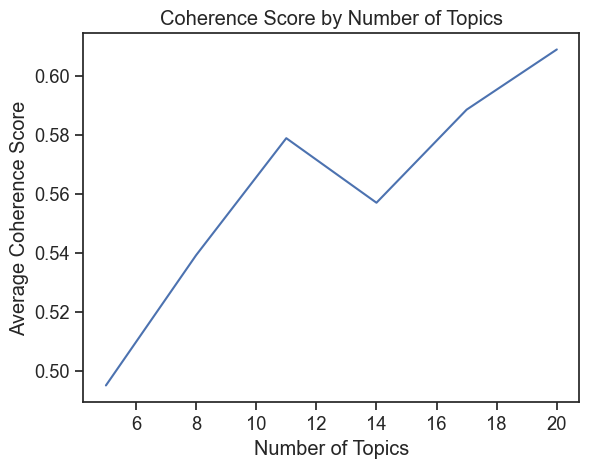

In [33]:
# Define a function to calculate the average consistency score for different topics
def calculate_average_coherence(texts, min_topics, max_topics, step):
    coherence_scores = []
    # Iterate over the number of topics within the specified range
    for k in range(min_topics, max_topics + 1, step):
        model = tp.LDAModel(k=k)
        # Add texts for the model
        for text in texts:
            model.add_doc(text.strip().split())
        # Train the model
        model.train(200) 
        # Calculate the coherence of the current model
        coh = tp.coherence.Coherence(model, coherence='c_v')
        average_coherence = coh.get_score()
        # Append the number of topics and the corresponding coherence score to the list
        coherence_scores.append((k, average_coherence))
        
        print(f"Topics: {k}, Average Coherence: {average_coherence}")
    # Return the list of coherence scores    
    return coherence_scores

# Execute the function to get coherence scores across different topic numbers
coherence_scores = calculate_average_coherence(training_data, 5, 20, 3)
# Unpack the list of tuples into two lists
topics, coherences = zip(*coherence_scores)

# Plot
plt.plot(topics, coherences)
plt.xlabel('Number of Topics')
plt.ylabel('Average Coherence Score')
plt.title('Coherence Score by Number of Topics')
plt.show()

### Q7. Topic distributions
Calculate the topic distributions for all tweets and get the top documents for some topics (between 2 and 5) that you think could be more representative of Sanders or Trump.

In [34]:
# Adapted from Week 6 Notebook
topic_distributions = [list(doc.get_topic_dist()) for doc in model.docs]

In [35]:
topics = [' '.join(word for word, prob in model.get_topic_words(topic_id=i, top_n=num_topic_words)) for i in range(model.k)]

In [38]:
from IPython.display import Markdown, display
import re

# Display the incoming string in Markdown format
def make_md(string):
    display(Markdown(str(string)))
    
# Get the top documents for selected topics
def get_top_docs(docs, topic_distributions, topic_index, n=5):

    sorted_data = sorted([(_distribution[topic_index], _document)
                          for _distribution, _document
                          in zip(topic_distributions, docs)], reverse=True)

    topic_words = topics[topic_index]

    make_md(f"### ✨Topic {topic_index}✨\n\n{topic_words}\n\n")
    print("---")

    for probability, doc in sorted_data[:n]:
        # Make topic words bolded
        for word in topic_words.split():
            if word in doc:
                doc = re.sub(f"\\b{word}\\b", f"**{word}**", doc, re.IGNORECASE)

        make_md(f'✨  \n**Topic Probability**: {probability}  \n**Document**: {doc}\n\n')


    return

In [39]:
# Display top documents for Topic 5, 9 and 14
get_top_docs(original_texts, topic_distributions, topic_index=5, n=5)
get_top_docs(original_texts, topic_distributions, topic_index=9, n=5)
get_top_docs(original_texts, topic_distributions, topic_index=14, n=5)

### ✨Topic 5✨

change people must climate energy together stand fossil us trump



---


✨  
**Topic Probability**: 0.9317666888237  
**Document**: While the top 1% own twice as much wealth as the bottom 99% of humanity, 420 million **people** throughout the world are in danger of slipping into extreme poverty and 30 million children are at risk of dying from hunger. We cannot allow that to happen. https://t.co/tvCiebEMSx



✨  
**Topic Probability**: 0.9239187240600586  
**Document**: While big banks and large corporations are able to borrow money for virtually no interest, it is absolutely unacceptable that low-income Americans are being charged 400% interest on a $375 payday loan. We need to put predatory lenders out of business and move to postal banking.



✨  
**Topic Probability**: 0.9239187240600586  
**Document**:  RT @realDonaldTrump: https://t.co/FDUVk8cm9S



✨  
**Topic Probability**: 0.914030909538269  
**Document**: American taxpayers are already funding the development of a coronavirus vaccine. When it is ready, we **must** put it in the public domain and ensure that it's available to all.

No more privatizing, monopolizing and profiteering by Big Pharma. https://t.co/yAh8tFjpep



✨  
**Topic Probability**: 0.910137951374054  
**Document**: The ecological crisis has gotten worse and worse, decade after decade, and yet the corporate media still refuse to take it seriously.

We will not bring about the political **change** needed to tackle the **climate** emergency until we address this. https://t.co/6MIbAu8izH



### ✨Topic 9✨

democrats impeachment president house witch hunt collusion nothing schiff call



---


✨  
**Topic Probability**: 0.9011295437812805  
**Document**:  FIND YOUR POLLING LOCATION HERE! https://t.co/0rnhb4z3HU



✨  
**Topic Probability**: 0.8940882682800293  
**Document**:  “The Democrats are trashing this President, &amp; in the process, trashing the U.S. Constitution. Frankly, the American People need to wake up to the reality that the Democrats are so drunk on power that they’re willing to destroy this Constitutional Republic.” @GrahamLedger @OANN



✨  
**Topic Probability**: 0.8772422075271606  
**Document**:  “Just another abuse of power in a long series of abuses of power by the Democrats that began during the Obama Administration, continued through the Mueller FBI operation, &amp; now the baton has been passed to Jerry Nadler to continue to abuse power to harass President Trump..



✨  
**Topic Probability**: 0.8691034317016602  
**Document**:  RT @SteveScalise: Same story, different day for Dems.   They’ve wanted to impeach @realDonaldTrump from Day 1.  First they tried to use the Mueller Report. When that didn’t work, they started pushing a hoax about a phone **call**.  The American people can see through their partisan schemes. https://t.co/MdnHfGv8x0



✨  
**Topic Probability**: 0.8691034317016602  
**Document**:  In one year Tariffs have rebuilt our Steel Industry - it is booming! We placed a 25% Tariff on “dumped” steel from China &amp; other countries, and we now have a big and growing industry. We had to save Steel for our defense and auto industries, both of which are coming back strong!



### ✨Topic 14✨

biden joe would dont president want trump know like people



---


✨  
**Topic Probability**: 0.8808794021606445  
**Document**:  FBI Director Christopher Wray just admitted that the FISA Warrants and Survailence of my campaign were illegal. So was the Fake Dossier. THEREFORE, THE WHOLE SCAM INVESTIGATION, THE MUELLER REPORT AND EVERYTHING ELSE FOR THREE YEARS, WAS A FIXED HOAX. WHO PAYS THE PRICE?....



✨  
**Topic Probability**: 0.8472039103507996  
**Document**:  ...The far-left maniacs supporting Joe Biden are burning flags and chanting “America was never great.” But we **know** the truth: America is the most Exceptional Nation on earth, and our destiny is blessed by God!



✨  
**Topic Probability**: 0.841446042060852  
**Document**:  RT @SteveScalise: President Trump's legal team completely destroyed 3 days of Adam Schiff's false allegations in just 2 hours. Today was devastating for the Democrats' case.  @realDonaldTrump will be vindicated.  Democrats tore the country apart for 3 years for nothing. Shameful.



✨  
**Topic Probability**: 0.809997022151947  
**Document**:  Wow! https://t.co/90GHsQRBAB



✨  
**Topic Probability**: 0.809997022151947  
**Document**:  China gets 91% of its Oil from the Straight, Japan 62%, &amp; many other countries likewise. So why are we protecting the shipping lanes for other countries (many years) for zero compensation. All of these countries should be protecting their own ships on what has always been....



Interpret the results above. Are there topics that have top tweets only by one politician? Why do you think these topics are more representative of one of the two politicians' views?

# Q7b (words)

✨Topic 5✨: This topic focuses on topics about the courts, the President, the Supreme Court, investigations and political controversies. Most of the keywords refer to pilitical and legal issues. The tweets are all posted by Trump since these topics are closely related to himself and his political actions. In his presidency, Ukrain and the impeachment inquiry are important events. For instance, in his twwets, Trump mentions the withdrawal of U.S. troops in Syria and Turkey's subsequent actions, showing his pride in foreign policies. These tweets show that Trump likes using social media for political battles and criticizes his political rivals on the plarform.

✨Topic 9✨: This topic focuses on elections, electoral fraud and global and national governance. Some keywords such as "election","fraud" and "vote" indicate a concern for election integrity. Like Topic 5, the tweets are all posted by Trump as it particularly discusses election security and attacks on the media. When talking about Biden's immigration policies, Trump further reinforces his strict stance this issue. By employing Twitter to deliver his political preference, Trump mobilize his supporters and criticizes media.


✨Topic 14✨: This topic focuses on health care policy, the government's treatment of workers and small businesses, and positions against Trump and the Republican Party. The tweets on this topic may be posted bby Sanders since they show his concern for health care and economic inequality. In his tweets, Sanders praises the efforts to counter Trump and Republicans on economic bailouts in response to the outbreak. These tweets indicate his commitment to social justice and economic equality. Sanders tries to use social media to raise public awareness of these issues and to expand the rights of the population.

From the analysis above, it can be found that Trump likes to attack his political opponents, highlight his political accomplishments, and slam the media. Sanders focuses more on advancing social justice, economic reform, and health care policies.

## Large scale analysis

### Q8. Create a random sample of the whole dataset and visualize the topic distributions for the sampled tweets

In [40]:
! pip install --upgrade matplotlib seaborn

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample
import tomotopy as tp

In [42]:
# Crete a sample of tweets
from random import sample
target_labels = sample(titles,100)

In [43]:
sns.set(style='ticks', font_scale=1.2)

def plot_categories_by_topics_heatmap(labels, topic_distributions, topic_keys, output_path=None, target_labels=None, color_map=sns.cm.rocket_r, dim=None):
    # Combine the labels and distributions into a list of dictionaries
    dicts_to_plot = []
    # Ensure the index scope of the topic keys
    max_topic_index = len(topic_keys) - 1
    for _label, _distribution in zip(labels, topic_distributions):
        if not target_labels or _label in target_labels:
            for _topic_index, _probability in enumerate(_distribution):
                if _topic_index > max_topic_index:
                    continue
                topic_description = ' '.join(topic_keys[_topic_index][:5])
                dicts_to_plot.append({'Probability': float(_probability),
                                      'Category': _label,
                                      'Topic': f'Topic {_topic_index:02}: {topic_description}'})

    # Create a dataframe, format it for the heatmap function, and normalize the columns
    df_to_plot = pd.DataFrame(dicts_to_plot)
    df_wide = df_to_plot.pivot_table(index='Category', columns='Topic', values='Probability')
    df_norm_col = (df_wide - df_wide.mean()) / df_wide.std()

    # Show the final plot
    if dim:
        plt.figure(figsize=dim)
    sns.set(style='ticks', font_scale=1.2)
    ax = sns.heatmap(df_norm_col, cmap=color_map)
    ax.xaxis.tick_top() 
    ax.xaxis.set_label_position('top')
    plt.xticks(rotation=30, ha='left')
    plt.tight_layout()
    plt.show()

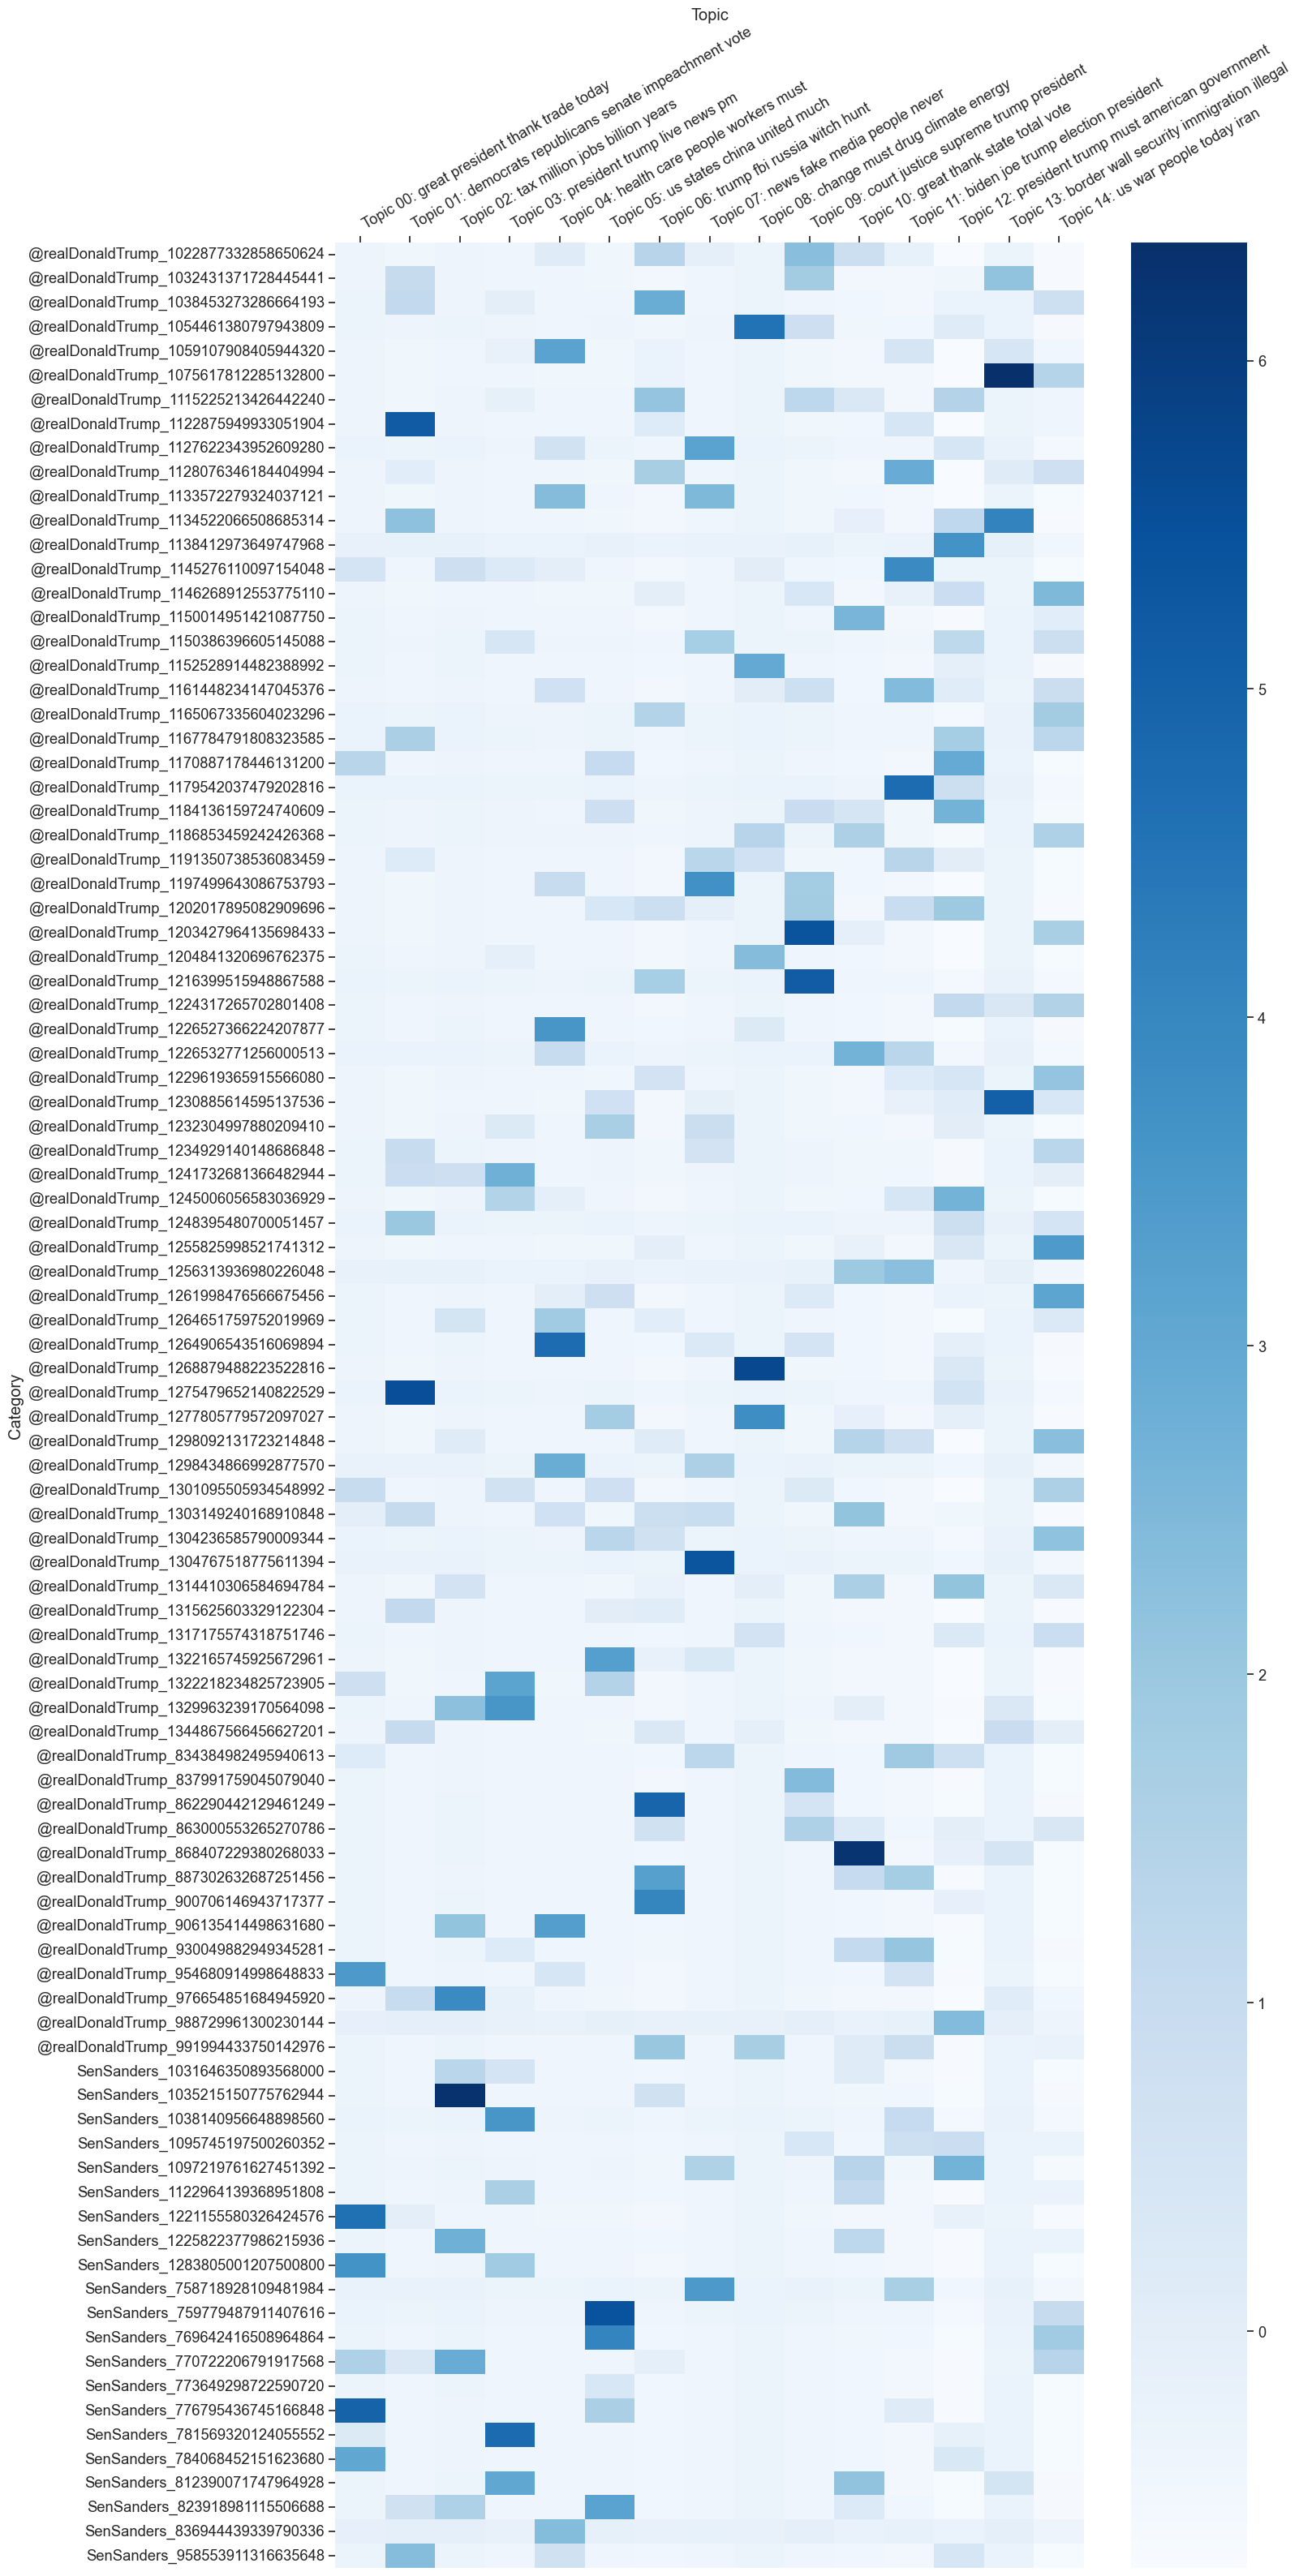

In [44]:
plot_categories_by_topics_heatmap(titles,
                                  topic_distributions,
                                  topic_individual_words,
                                  target_labels=target_labels,
                                  color_map = 'Blues',
                                 dim=(16,32))

### Q9. Interpret the heatmap
Do you see any pattern in the probability distributions of topics for each politician?

Are there topics that are more likely for one of the two politicians?

# Q9 (words)

In Trump's tweets, the rows about topics such as "military," "legal" and "presidential" are darker, reflecting his focus on defense, legal issues and his personal political image. Trump may often discuss defense policy, law enforcement issues, or his presidential duties and performance in Twitter. Besides, topics related to political campaigns, such as "election", also show a high probability as Trump is active in social media during the election campaign and his administration.

In Sanders' tweets, the rows about topics such as "health insurance", "climate change" and "workers' rights" are darker, suggesting that his focus on the health care system, climate change and labor conditions. Sanders also often talks about social justice and economic equality, which are in line with his political philosophy. 

To conclude, in terms of their topic preference, Trump focuses more on national security, law, election and military while Sanders pays more attention to  social welfare, environmental protection and workers' wage. 

### X2. Optional question 2
(This question is not compulsory, it only allows you to get an extra point)

Make the sample balanced, with 50 tweets by Trump and 50 by Sanders.

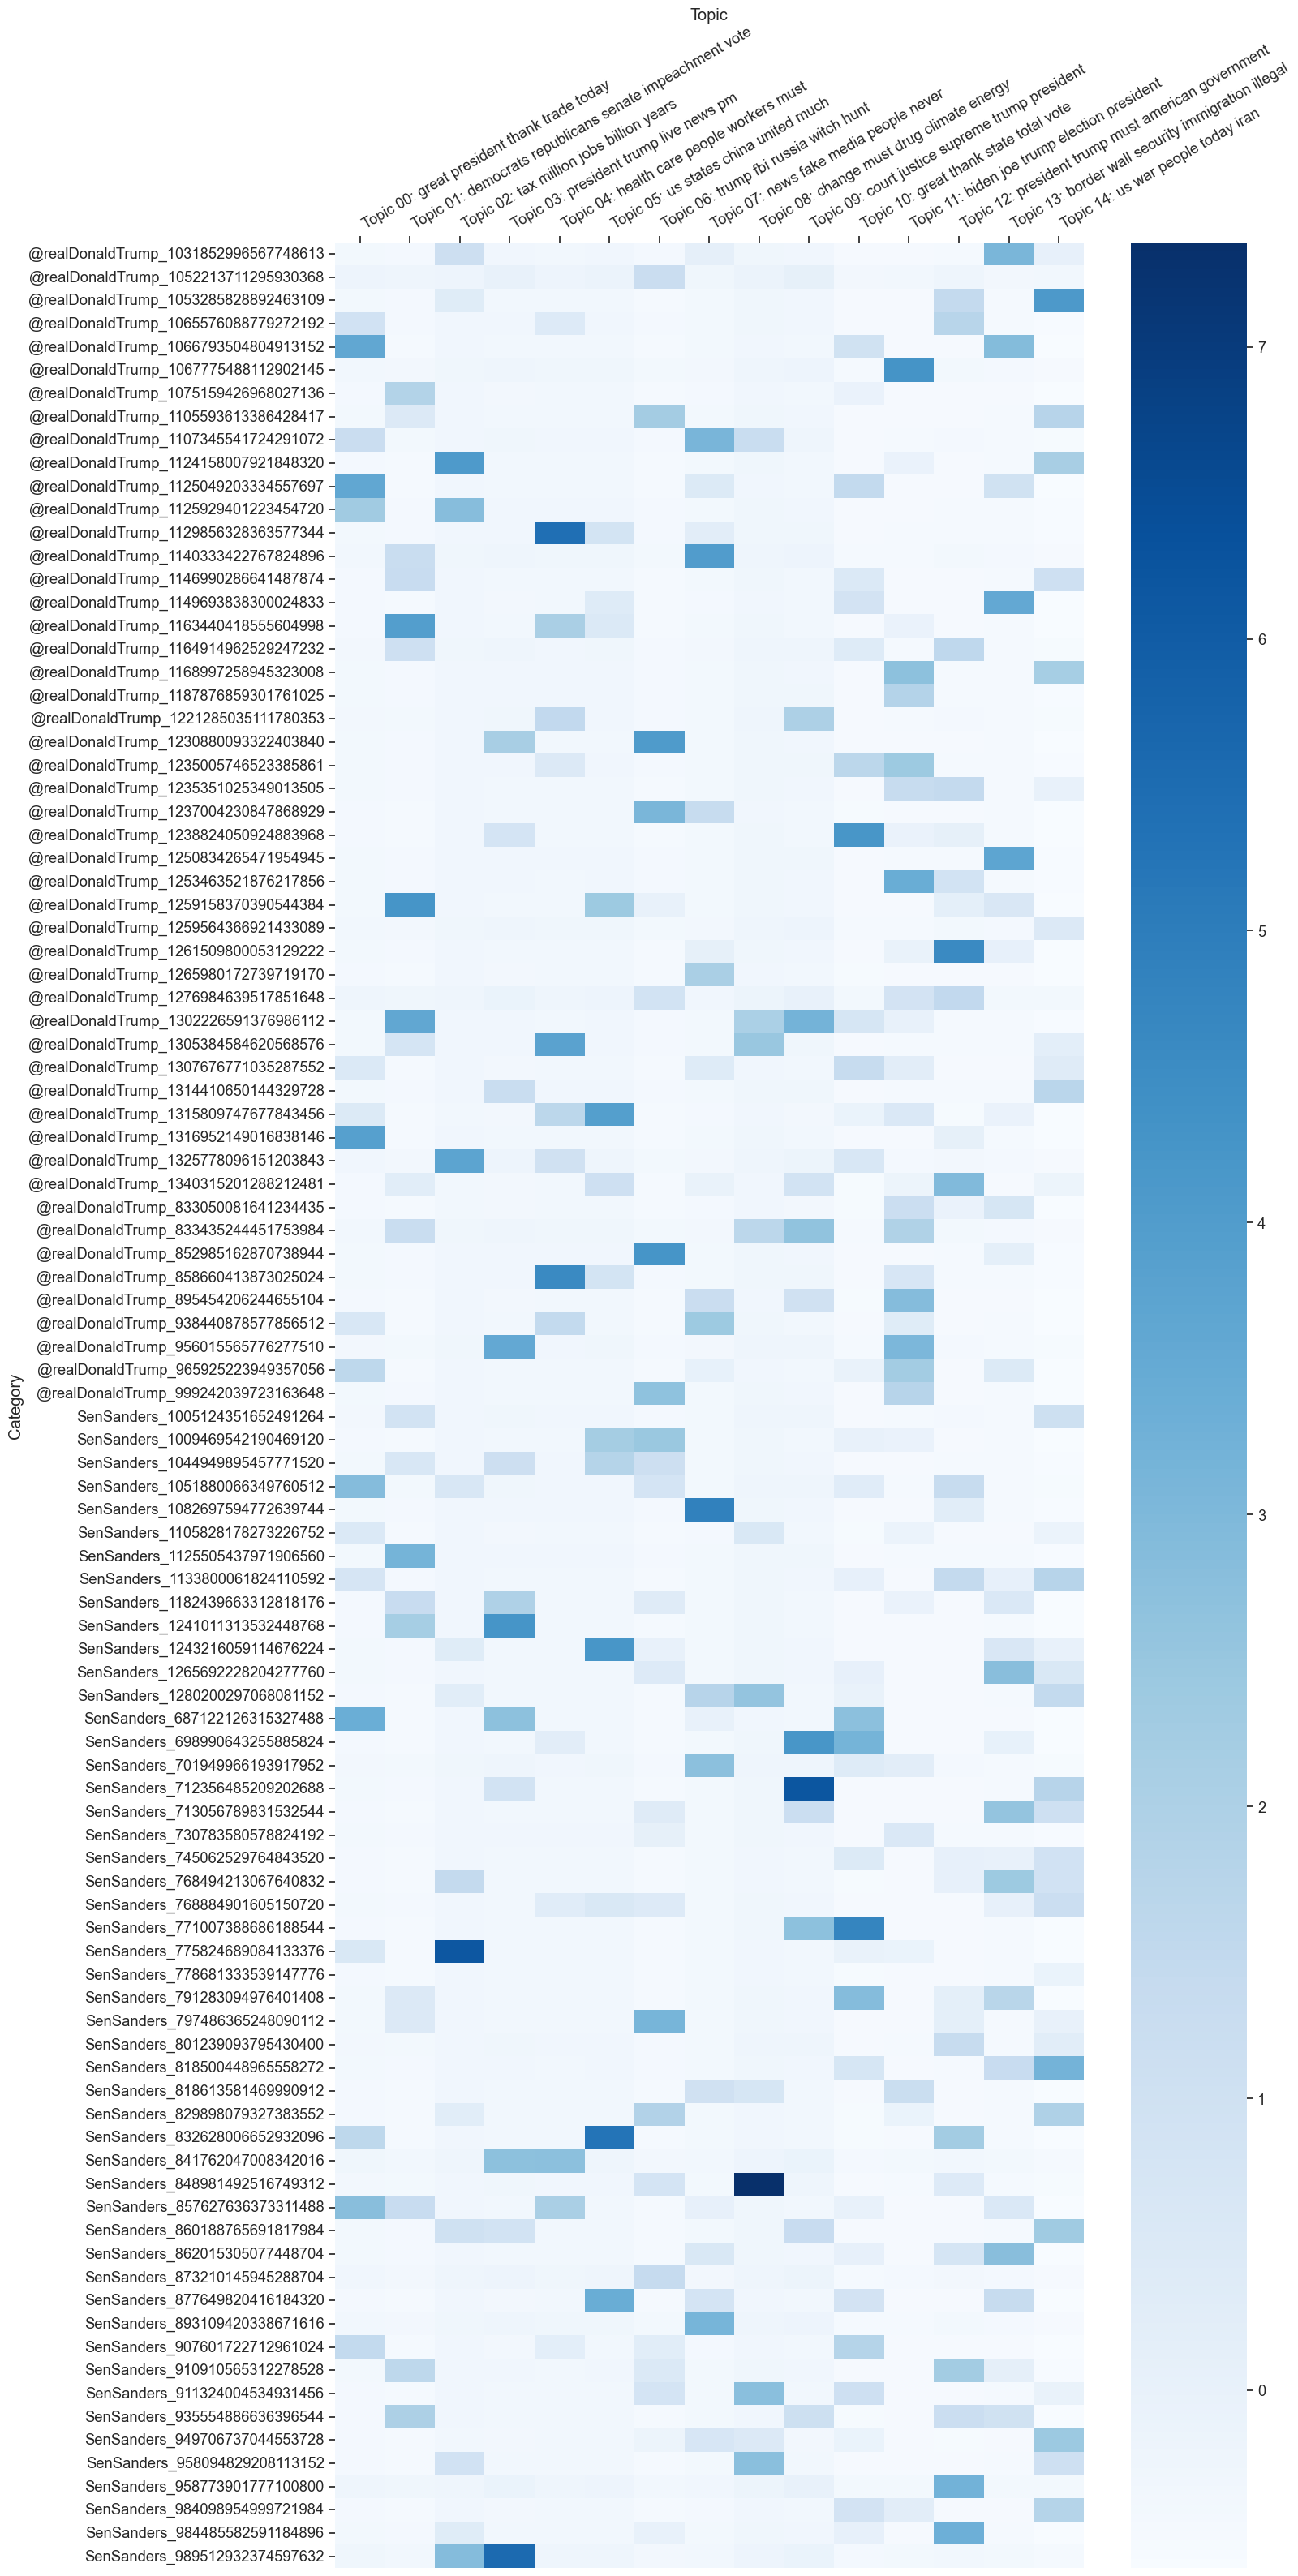

In [46]:
Trump_Tweets = [title for title in titles if 'Trump' in title]
Sanders_Tweets = [title for title in titles if 'Sanders' in title]

# Sample 50 tweets from each politician's tweets
Trump_sample = sample(Trump_Tweets, 50)
Sanders_sample = sample(Sanders_Tweets, 50)

# Combine two new samples together
balanced_sample = Trump_sample + Sanders_sample

# Draw a heat map
plot_categories_by_topics_heatmap(balanced_sample,
                                  topic_distributions,
                                  topic_individual_words,
                                  target_labels=balanced_sample,
                                  color_map='Blues',
                                  dim=(16, 32))

### X3. Optional question 3
(This question is not compulsory, it only allows you to get an extra point)

Extend the analysis to all the tweets in the dataset.

In [48]:
# X3 (code and words)
# Tip: plotting a heatmap for thousands of tweets is not practical.
# Make a comparison based on the numerical values in the `df_norm_col` dataframe (see Week 6 notebook)
import numpy as np

topic_distributions_np = np.array(topic_distributions)

# Calculate the average of the topic distribution of Trump and Sanders' tweets
trump_indices = [i for i, title in enumerate(titles) if 'Trump' in title]
sanders_indices = [i for i, title in enumerate(titles) if 'Sanders' in title]

# Ensure index validity
valid_trump_indices = [i for i in trump_indices if i < len(topic_distributions_np)]
valid_sanders_indices = [i for i in sanders_indices if i < len(topic_distributions_np)]

# Calculate the average distribution
mean_distributions_trump = np.mean(topic_distributions_np[valid_trump_indices, :], axis=0)
mean_distributions_sanders = np.mean(topic_distributions_np[valid_sanders_indices, :], axis=0)


# Creat df_norm_col dataframe
df_norm_col = pd.DataFrame({
    'Trump': mean_distributions_trump,
    'Sanders': mean_distributions_sanders
})

# Use the topic number as the row index
df_norm_col.index = [f'Topic {i}' for i in range(1, len(mean_distributions_trump) + 1)]

# Compare the average distribution between Trump and Sanders on various topics
print(df_norm_col)

# Calculate the topics with the greatest differences
df_norm_col['Difference'] = np.abs(df_norm_col['Trump'] - df_norm_col['Sanders'])
print(df_norm_col.sort_values(by='Difference', ascending=False))

             Trump   Sanders
Topic 1   0.032186  0.075557
Topic 2   0.044343  0.030763
Topic 3   0.031746  0.059550
Topic 4   0.038710  0.140416
Topic 5   0.049897  0.030741
Topic 6   0.032814  0.103989
Topic 7   0.080773  0.031251
Topic 8   0.053680  0.015919
Topic 9   0.043573  0.010184
Topic 10  0.065590  0.023939
Topic 11  0.055823  0.025467
Topic 12  0.073529  0.029600
Topic 13  0.093132  0.043155
Topic 14  0.041585  0.023428
Topic 15  0.078780  0.050515
Topic 16  0.039892  0.075028
Topic 17  0.037217  0.020725
Topic 18  0.045887  0.022990
Topic 19  0.033021  0.130722
Topic 20  0.027822  0.056060
             Trump   Sanders  Difference
Topic 4   0.038710  0.140416    0.101706
Topic 19  0.033021  0.130722    0.097701
Topic 6   0.032814  0.103989    0.071175
Topic 13  0.093132  0.043155    0.049977
Topic 7   0.080773  0.031251    0.049522
Topic 12  0.073529  0.029600    0.043929
Topic 1   0.032186  0.075557    0.043371
Topic 10  0.065590  0.023939    0.041651
Topic 8   0.053680  0.

Topic 4 is extremely important for Sanders, with a value of 0.140416. The figure is much higher than Trump's 0.038710 with a difference of 0.038710. This indicates that Sanders' tweets focus much on this topic. Topic 2 has the smallest difference at 0.013580, indicating that Trump and Sanders paye nearly the same attention on that topic. This topic may be important or unimportant to both of them.